# Multi-Field Multi-Prompt Extraction Experiment

This notebook implements a comprehensive experiment to test different prompts for extracting multiple fields (work order and cost) from invoices.

## Overview
- Work Order Extraction: Testing basic, detailed, positioned, formatted, and chain-of-thought prompts
- Cost Extraction: Testing basic, detailed, positioned, and formatted prompts
- Comparative analysis of prompt performance across fields


## Environment Setup
### Import Libraries

In [1]:
# Import Required Libraries
! pip install seaborn
import os
import sys
import json
import time
import logging
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Any, Optional, Tuple, Union

# Data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image
from Levenshtein import distance

# Deep learning libraries
import torch
import torch.nn as nn
import transformers
from transformers import (
    AutoProcessor,
    AutoModelForVision2Seq,
    AutoTokenizer,
    LlavaForConditionalGeneration,
    BitsAndBytesConfig
)


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


### Establish Root Path

In [2]:

# Add project root to path for imports
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Added {project_root} to Python path")

Added /workspace to Python path


### Set up Paths

In [3]:
# Import path configuration utility
from src.config.paths import get_path_config

# Create timestamp for this experiment
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_name = f"multi_field_experiment_{timestamp}"

# Get path configuration
paths = get_path_config(experiment_name=experiment_name)

# Create a dictionary-like representation for backward compatibility
paths_dict = {
    "project_root": Path(paths.base_dir),
    "data_dir": Path(paths.data_dir),
    "images_dir": Path(paths.images_dir),
    "ground_truth_file": Path(paths.ground_truth_path),
    "configs_dir": Path(paths.base_dir) / "configs",
    "results_dir": Path(paths.experiment_dir),
    "logs_dir": Path(paths.base_dir) / "logs"
}

# Use the paths_dict for further operations
experiment_paths = paths_dict

# Create results directory structure
for directory in ["work_order", "cost", "combined"]:
    subdir = paths_dict["results_dir"] / directory
    subdir.mkdir(parents=True, exist_ok=True)
    (subdir / "visualizations").mkdir(exist_ok=True)
    (subdir / "raw").mkdir(exist_ok=True)
    (subdir / "processed").mkdir(exist_ok=True)

### Import Local Modules

In [4]:
# Import project modules
from src.config.environment import get_environment_config
from src.config.paths import get_path_config
from src.config.experiment import get_experiment_config
from src.models.loader import load_model_and_processor, get_gpu_memory_info
from src.models.registry import get_model_config
from src.prompts.registry import get_prompt, list_all_prompts
from src.execution.pipeline import ExtractionPipeline
from src.results.collector import ResultsCollector
from src.analysis.visualization import create_visualizations

### Configure Logging

In [5]:
# Configure Logging
# Create logs directory if it doesn't exist
logs_dir = Path(paths.base_dir) / "logs"
logs_dir.mkdir(parents=True, exist_ok=True)

# Set up log file path
log_filename = f"extraction_{timestamp}.log"
log_path = logs_dir / log_filename

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_path),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger('multi_field_extraction')
logger.info("Starting multi-field extraction experiment")

# 4. Check Environment & GPU Status
# Basic environment checks
print("🔧 Checking environment setup...")
python_version = sys.version.split()[0]
print(f"📌 Python Version: {python_version}")

# Check CUDA availability
cuda_available = torch.cuda.is_available()
if cuda_available:
    print("💻 CUDA Information:")
    print(f"   Available: Yes")
    print(f"   Version: {torch.version.cuda}")
    print(f"   Device: {torch.cuda.get_device_name(0)}")
    print(f"   Device Count: {torch.cuda.device_count()}")
    print(f"   Memory Available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
else:
    print("⚠️ CUDA not available, using CPU")

2025-03-28 00:05:46,677 - multi_field_extraction - INFO - Starting multi-field extraction experiment


🔧 Checking environment setup...
📌 Python Version: 3.10.12
💻 CUDA Information:
   Available: Yes
   Version: 11.8
   Device: NVIDIA H100 NVL
   Device Count: 1
   Memory Available: 99.86 GB


### Configure Environment

In [6]:
# Load and Configure Environment Settings
# Get environment configuration
env_config = get_environment_config()
print(f"📌 Detected environment: {env_config.environment}")

# Set up experiment base configuration
experiment_base = {
    "name": experiment_name,
    "description": "Multi-field prompt comparison for invoice data extraction",
    "model_name": "pixtral-12b",
    "model_repo_id": "mistral-community/pixtral-12b",
    "timestamp": timestamp,
    "environment": env_config.environment,
    "batch_size": 1 if env_config.environment == "local" else 4,
    "use_half_precision": True if cuda_available else False,
    "use_4bit_quantization": env_config.environment == "runpod",
    "device": "cuda" if cuda_available else "cpu"
}

# Save basic environment info
env_info = {
    "timestamp": timestamp,
    "python_version": python_version,
    "cuda_available": cuda_available,
    "cuda_version": torch.version.cuda if cuda_available else None,
    "torch_version": torch.__version__,
    "transformers_version": transformers.__version__,
    "environment": env_config.environment,
    "gpu_info": {
        "name": torch.cuda.get_device_name(0) if cuda_available else None,
        "count": torch.cuda.device_count() if cuda_available else 0,
        "memory_gb": torch.cuda.get_device_properties(0).total_memory/1e9 if cuda_available else 0
    },
    "experiment_base": experiment_base
}

# Use get_results_path method to save environment info
env_info_path = Path(paths.get_results_path("environment_info.json"))
with open(env_info_path, "w") as f:
    json.dump(env_info, f, indent=2)

print(f"💾 Environment info saved to: {env_info_path}")
print("✅ Environment setup complete!")

# Make paths and configurations available for other cells
experiment_paths = paths.to_dict()  # Convert to dictionary for backward compatibility
environment_config = env_config

📌 Detected environment: runpod
💾 Environment info saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/environment_info.json
✅ Environment setup complete!


## Configuration Management
This section loads field-specific configurations from YAML files and creates a unified configuration dictionary for the experiment
### Load Configs

In [7]:
# Load and Configure Model
import yaml
import re
from dataclasses import dataclass, field, asdict

# Function to load YAML configuration
def load_yaml_config(file_path):
    """Load configuration from a YAML file"""
    try:
        with open(file_path, 'r') as f:
            return yaml.safe_load(f)
    except Exception as e:
        logger.error(f"Error loading config file {file_path}: {e}")
        return {}

# Function to validate field configuration
def validate_field_config(config, field_name):
    """Validate field-specific configuration settings"""
    required_keys = ["ground_truth_column", "prompt_categories", "metrics", "validation"]
    missing_keys = [key for key in required_keys if key not in config]
    
    if missing_keys:
        raise ValueError(f"Missing required configuration keys for {field_name}: {', '.join(missing_keys)}")
    
    # Validate metrics configuration
    if "primary" not in config["metrics"]:
        raise ValueError(f"Missing primary metric for {field_name}")
    
    # Validate prompt categories
    if not config["prompt_categories"] or not isinstance(config["prompt_categories"], list):
        raise ValueError(f"Invalid prompt categories for {field_name}")
    
    # Validate validation rules (pattern is required)
    if "pattern" not in config["validation"]:
        raise ValueError(f"Missing validation pattern for {field_name}")
    
    # Test that the pattern is a valid regex
    try:
        re.compile(config["validation"]["pattern"])
    except re.error:
        raise ValueError(f"Invalid validation pattern for {field_name}: {config['validation']['pattern']}")
    
    return True

print("📋 Loading field-specific configurations...")

📋 Loading field-specific configurations...


### Load global Configs

In [8]:
# Load global configuration
global_config_path = Path(paths.base_dir) / "configs" / "experiment.yaml"
global_config = load_yaml_config(global_config_path)

if not global_config:
    # Create default global configuration if file is missing or empty
    global_config = {
        "experiment_name": experiment_base["name"],
        "model_name": experiment_base["model_name"],
        "model_repo_id": experiment_base["model_repo_id"],
        "device": experiment_base["device"],
        "batch_size": experiment_base["batch_size"],
        "checkpointing": True,
        "checkpoint_frequency": 5
    }
    logger.warning(f"Using default global configuration, file not found: {global_config_path}")
else:
    logger.info(f"Loaded global configuration from {global_config_path}")

2025-03-28 00:05:58,070 - multi_field_extraction - INFO - Loaded global configuration from /workspace/configs/experiment.yaml


### Load Field-Specific Configs

In [9]:
# %% [markdown]
# ## Load Field-Specific Configurations
# 
# This section loads and configures field-specific settings for work orders and costs.

# %%
import json
import yaml
from pathlib import Path
import sys

print("📋 Loading field-specific configurations...")

# Ensure we can find the experiment config function
try:
    # Try different import approaches
    try:
        from src.config.experiment import get_experiment_config
        print("✅ Imported get_experiment_config from src.config.experiment")
    except ImportError:
        try:
            # Try alternate import path
            from config.experiment import get_experiment_config
            print("✅ Imported get_experiment_config from config.experiment")
        except ImportError:
            # Check if it's already in globals
            if 'get_experiment_config' not in globals():
                print("⚠️ Could not import get_experiment_config, trying to locate module")
                
                # Add potential paths to sys.path
                if 'experiment_paths' in globals() and 'src_dir' in experiment_paths:
                    sys.path.append(str(experiment_paths['src_dir']))
                    print(f"Added {experiment_paths['src_dir']} to sys.path")
                
                # Try one more time
                try:
                    from src.config.experiment import get_experiment_config
                    print("✅ Successfully imported get_experiment_config after path adjustment")
                except ImportError:
                    raise ImportError("Could not import get_experiment_config")
            else:
                print("✅ get_experiment_config already exists in globals")
    
    # Get or create experiment_config
    if 'experiment_config' not in globals():
        print("⚠️ experiment_config not found, creating new configuration")
        experiment_config = get_experiment_config().config
        print("✅ Created new experiment configuration")
    else:
        print("✅ Using existing experiment configuration")
    
except Exception as e:
    print(f"⚠️ Error setting up experiment configuration: {e}")
    
    # Create a minimal experiment config as fallback
    if 'experiment_config' not in globals():
        print("⚠️ Creating minimal experiment_config as fallback")
        experiment_config = {"fields": {}}

# 1. Work Order Configuration
work_order_config = {
    "field_to_extract": "work_order",
    "ground_truth_column": "Work Order Number/Numero de Orden",
    "prompt_categories": ["basic", "detailed", "positioned", "formatted", "chain_of_thought"],
    "metrics": {
        "primary": "exact_match",
        "secondary": ["character_error_rate", "levenshtein_distance", "processing_time"],
        "settings": {
            "case_sensitive": False,
            "strip_whitespace": True,
            "normalize_numbers": True
        }
    },
    "validation": {
        "pattern": r"^\d{5,7}$",
        "min_length": 5,
        "max_length": 7,
        "required_digits": True
    }
}

# 2. Cost Configuration
cost_config = {
    "field_to_extract": "cost",
    "ground_truth_column": "Total",
    "prompt_categories": ["basic", "detailed", "positioned", "formatted"],
    "metrics": {
        "primary": "exact_match",
        "secondary": ["numeric_difference", "percentage_error", "processing_time"],
        "settings": {
            "currency_symbol": "$",
            "decimal_places": 2,
            "allow_comma_separator": True,
            "strip_currency": True
        }
    },
    "validation": {
        "pattern": r"^\$?\d{1,7}(\.\d{2})?$",
        "min_value": 0,
        "max_value": 1000000,
        "required_decimal": True
    }
}

# 3. Override configurations from YAML files if they exist
# Check if experiment_paths exists
if 'experiment_paths' not in globals():
    print("⚠️ experiment_paths not found, skipping YAML overrides")
    configs_dir = Path("configs")  # Default fallback
else:
    if isinstance(experiment_paths, dict) and "configs_dir" in experiment_paths:
        configs_dir = experiment_paths["configs_dir"]
    else:
        configs_dir = Path("configs")  # Default fallback
    print(f"✅ Using configs directory: {configs_dir}")

# Look for field-specific config files
work_order_yaml = configs_dir / "fields" / "work_order.yaml"
cost_yaml = configs_dir / "fields" / "cost.yaml"

# Override work order config if file exists
if work_order_yaml.exists():
    try:
        with open(work_order_yaml, 'r') as f:
            work_order_yaml_config = yaml.safe_load(f)
        
        if work_order_yaml_config:
            # Deep update the config, preserving default values for missing keys
            for key, value in work_order_yaml_config.items():
                if isinstance(value, dict) and key in work_order_config and isinstance(work_order_config[key], dict):
                    # Merge dictionaries recursively
                    work_order_config[key].update(value)
                else:
                    work_order_config[key] = value
            print(f"✅ Overriding work order configuration from {work_order_yaml}")
    except Exception as e:
        print(f"⚠️ Error loading work order config file: {e}")

# Override cost config if file exists
if cost_yaml.exists():
    try:
        with open(cost_yaml, 'r') as f:
            cost_yaml_config = yaml.safe_load(f)
        
        if cost_yaml_config:
            # Deep update the config
            for key, value in cost_yaml_config.items():
                if isinstance(value, dict) and key in cost_config and isinstance(cost_config[key], dict):
                    # Merge dictionaries recursively
                    cost_config[key].update(value)
                else:
                    cost_config[key] = value
            print(f"✅ Overriding cost configuration from {cost_yaml}")
    except Exception as e:
        print(f"⚠️ Error loading cost config file: {e}")

# 4. Validate configurations
print("🔍 Validating field-specific configurations...")
try:
    # Simple validation checks
    required_keys = ["field_to_extract", "ground_truth_column", "prompt_categories", "metrics", "validation"]
    
    for config_name, config in [("work_order", work_order_config), ("cost", cost_config)]:
        missing_keys = [key for key in required_keys if key not in config]
        if missing_keys:
            raise ValueError(f"Missing required keys in {config_name} config: {', '.join(missing_keys)}")
        
        # Validate metrics
        if "primary" not in config["metrics"]:
            raise ValueError(f"Missing primary metric in {config_name} config")
        
        # Validate validation pattern
        if "pattern" not in config["validation"]:
            raise ValueError(f"Missing validation pattern in {config_name} config")
    
    print("✅ All field configurations valid")
except ValueError as e:
    print(f"⚠️ Configuration validation error: {e}")
    raise

# 5. Update experiment config with field configurations
if "fields" not in experiment_config:
    experiment_config["fields"] = {}

experiment_config["fields"]["work_order"] = work_order_config
experiment_config["fields"]["cost"] = cost_config

print("\n📊 Field Configuration Summary:")
print(f"\n📌 Work Order:")
print(f"  Ground Truth Column: {work_order_config['ground_truth_column']}")
print(f"  Prompt Categories: {', '.join(work_order_config['prompt_categories'])}")
print(f"  Primary Metric: {work_order_config['metrics']['primary']}")

print(f"\n📌 Cost:")
print(f"  Ground Truth Column: {cost_config['ground_truth_column']}")
print(f"  Prompt Categories: {', '.join(cost_config['prompt_categories'])}")
print(f"  Primary Metric: {cost_config['metrics']['primary']}")

print("\n✅ Field configurations loaded and validated")

2025-03-28 00:06:00,099 - src.config.experiment - INFO - Experiment configuration initialized


📋 Loading field-specific configurations...
✅ Imported get_experiment_config from src.config.experiment
⚠️ experiment_config not found, creating new configuration
✅ Created new experiment configuration
✅ Using configs directory: configs
🔍 Validating field-specific configurations...
✅ All field configurations valid

📊 Field Configuration Summary:

📌 Work Order:
  Ground Truth Column: Work Order Number/Numero de Orden
  Prompt Categories: basic, detailed, positioned, formatted, chain_of_thought
  Primary Metric: exact_match

📌 Cost:
  Ground Truth Column: Total
  Prompt Categories: basic, detailed, positioned, formatted
  Primary Metric: exact_match

✅ Field configurations loaded and validated


## Prompt Management & Selection
This section loads available prompts for different fields, displays them by category, and allows selection of which specific prompts to use in the experiment.

In [10]:
import pandas as pd
from src.prompts.registry import (
    get_registry, list_all_prompts, list_prompt_categories,
    get_prompts_by_field, load_all_prompt_configs,
    Prompt, register_prompt, PromptRegistry
)
from src.results.schema import (
    PromptPerformance, 
    IndividualExtractionResult, 
    ExtractionStatus
)
from src.config.experiment import get_experiment_config

print("🔤 Loading and configuring prompts...")

# Get experiment configuration
experiment_config = get_experiment_config().config

# 1. Load all available prompts from configuration files
registry = get_registry()

try:
    # Load from configs directory
    load_all_prompt_configs(Path(paths.base_dir) / "configs" / "prompts")
    print(f"✅ Loaded prompts from configuration")
except FileNotFoundError as e:
    print(f"⚠️ {str(e)}")
    print("  Using default prompts only")

# Rest of the code remains the same

# 2. Display available prompts by field
available_fields = ["work_order", "cost"]  # Using hardcoded fields as per your preference
print(f"\n📋 Available fields for extraction: {', '.join(available_fields)}")

all_prompts = []
field_prompt_objects = {}  # Store actual prompt objects by field

for field in available_fields:
    field_prompts = registry.get_by_field(field)
    print(f"\n📌 {field.upper()} Prompts:")
    
    field_prompt_objects[field] = []
    
    for i, prompt in enumerate(field_prompts, 1):
        # Create readable prompt summary
        category_tag = f"[{prompt.category}]"
        print(f"  {i}. {category_tag:12} {prompt.name:20} - {prompt.description}")
        
        # Add to the list of all prompts
        prompt_dict = prompt.to_dict()
        
        # Enhance with schema-related metadata
        prompt_dict['schema_metadata'] = {
            'expected_status': ExtractionStatus.SUCCESS,
            'confidence_threshold': 0.8,
            'error_handling': 'log_and_continue',
            'field': field
        }
        
        # Create a template PromptPerformance for tracking
        prompt_performance_template = PromptPerformance(
            prompt_name=prompt_dict['name'],
            field=field
        )
        prompt_dict['performance_template'] = prompt_performance_template.to_dict()
        
        all_prompts.append(prompt_dict)
        field_prompt_objects[field].append(prompt)

# 3. Create a DataFrame for easier filtering and selection
prompts_df = pd.DataFrame(all_prompts) if all_prompts else pd.DataFrame()
if len(prompts_df) > 0:
    # Display summary statistics
    print("\n📊 Prompt Statistics:")
    print(f"  Total prompts: {len(prompts_df)}")
    
    category_counts = prompts_df['category'].value_counts()
    print(f"  Categories: {', '.join(category_counts.index.tolist())}")
    
    field_counts = prompts_df['field_to_extract'].value_counts()
    print(f"  Fields: {', '.join(field_counts.index.tolist())}")
else:
    print("\n⚠️ No prompts available - creating default prompts")
    
    # Create default work order prompts
    register_prompt(Prompt(
        name="basic_work_order",
        text="Extract the work order number from this invoice image.",
        category="basic",
        field_to_extract="work_order",
        description="Simple direct prompt that worked well in initial RunPod tests."
    ))
    
    # More detailed prompt for work order
    register_prompt(Prompt(
        name="detailed_work_order",
        text="This is an invoice image. Find and extract the work order number from this invoice. The work order number is typically labeled as 'Work Order Number' or 'Numero de Orden'.",
        category="detailed",
        field_to_extract="work_order",
        description="More detailed prompt with field label information."
    ))
    
    # Create default cost prompts
    register_prompt(Prompt(
        name="basic_cost",
        text="Extract the total cost from this invoice image.",
        category="basic",
        field_to_extract="cost",
        description="Simple direct prompt for cost extraction."
    ))
    
    # More detailed prompt for cost
    register_prompt(Prompt(
        name="detailed_cost",
        text="This is an invoice image. Find and extract the total cost or amount from this invoice. The total cost is usually at the bottom and may be labeled as 'Total', 'Amount Due', or 'Total Cost'.",
        category="detailed",
        field_to_extract="cost",
        description="More detailed prompt with field label information."
    ))
    
    print("✅ Created default prompts for work_order and cost fields")
    
    # Refresh available prompts
    all_prompts = []
    field_prompt_objects = {}
    
    for field in available_fields:
        field_prompt_objects[field] = []
        for prompt in registry.get_by_field(field):
            prompt_dict = prompt.to_dict()
            
            # Enhance with schema-related metadata
            prompt_dict['schema_metadata'] = {
                'expected_status': ExtractionStatus.SUCCESS,
                'confidence_threshold': 0.8,
                'error_handling': 'log_and_continue',
                'field': field
            }
            
            # Create a template PromptPerformance for tracking
            prompt_performance_template = PromptPerformance(
                prompt_name=prompt.name,
                field=field
            )
            prompt_dict['performance_template'] = prompt_performance_template.to_dict()
            
            all_prompts.append(prompt_dict)
            field_prompt_objects[field].append(prompt)
    
    prompts_df = pd.DataFrame(all_prompts) if all_prompts else pd.DataFrame()

# 4. Interactive prompt selection using text input
print("\n🔍 Select specific prompts to use for each field:")

# Dictionary to store selected prompts
selected_prompts_by_field = {}

for field in available_fields:
    print(f"\n  {field.upper()} prompts:")
    
    # Display prompts with numbers
    for i, prompt in enumerate(field_prompt_objects[field], 1):
        category_tag = f"[{prompt.category}]"
        print(f"    {i}. {category_tag:12} {prompt.name:20} - {prompt.description}")
    
    # Get user selection
    selection = input(f"\n  Enter prompt numbers for {field} (comma-separated, e.g. 1,3,4) or 'all': ")
    
    if selection.strip().lower() == 'all':
        # Select all prompts
        selected_prompts_by_field[field] = field_prompt_objects[field]
        print(f"  ✅ Selected all {len(field_prompt_objects[field])} prompts for {field}")
    else:
        # Parse selected indices
        try:
            # Split by comma and convert to integers
            selected_indices = [int(idx.strip()) - 1 for idx in selection.strip().split(',') if idx.strip()]
            
            # Validate indices
            valid_indices = [idx for idx in selected_indices if 0 <= idx < len(field_prompt_objects[field])]
            
            if valid_indices:
                # Get prompts for valid indices
                selected_prompts_by_field[field] = [field_prompt_objects[field][idx] for idx in valid_indices]
                print(f"  ✅ Selected {len(selected_prompts_by_field[field])} prompts for {field}")
                
                # List selected prompts
                for i, prompt in enumerate(selected_prompts_by_field[field], 1):
                    print(f"      {i}. [{prompt.category}] {prompt.name}")
            else:
                # Default to all prompts if no valid indices
                selected_prompts_by_field[field] = field_prompt_objects[field]
                print(f"  ⚠️ No valid selections. Using all prompts for {field}")
        except:
            # Handle any errors
            print(f"  ⚠️ Error in selection. Using all prompts for {field}")
            selected_prompts_by_field[field] = field_prompt_objects[field]
    
    # Update experiment config with selected categories
    selected_categories = list(set(prompt.category for prompt in selected_prompts_by_field[field]))
    if "fields" not in experiment_config:
        experiment_config["fields"] = {}
    if field not in experiment_config["fields"]:
        experiment_config["fields"][field] = {}
    experiment_config["fields"][field]["prompt_categories"] = selected_categories
    print(f"  Updated experiment config with categories: {', '.join(selected_categories)}")

# Process selected prompts
processed_prompts = {}
all_selected_prompts = []

for field, prompts in selected_prompts_by_field.items():
    processed_prompts[field] = []
    
    for prompt in prompts:
        # Create prompt dictionary
        prompt_dict = prompt.to_dict()
        
        # Add schema metadata
        prompt_dict['schema_metadata'] = {
            'expected_status': ExtractionStatus.SUCCESS,
            'confidence_threshold': 0.8,
            'error_handling': 'log_and_continue',
            'field': field
        }
        
        # Create performance template
        prompt_performance = PromptPerformance(
            prompt_name=prompt_dict['name'],
            field=field
        )
        prompt_dict['performance_template'] = prompt_performance.to_dict()
        
        # Add formatted text for the model
        model_name = experiment_config.get("global", {}).get("model_name", "pixtral-12b")
        if isinstance(model_name, str) and model_name.startswith("pixtral"):
            prompt_dict["formatted_text"] = f"<s>[INST]{prompt.text}\n[IMG][/INST]"
        else:
            prompt_dict["formatted_text"] = prompt.text
        
        # Add to processed prompts
        processed_prompts[field].append(prompt_dict)
        all_selected_prompts.append(prompt_dict)

# Count selected prompts
total_selected = sum(len(prompts) for prompts in processed_prompts.values())

print(f"\n✅ Ready to proceed with {total_selected} selected prompts")
print(f"  Fields: {', '.join(processed_prompts.keys())}")

# Make prompts available for other cells
prompt_management = {
    "all_prompts": all_prompts,
    "selected_prompts": processed_prompts,
    "all_selected_prompts": all_selected_prompts
}

print("\n✅ Prompt management has been set up and is ready for use in subsequent cells")
print(f"  - selected_prompts: {len(prompt_management['selected_prompts'])} fields")
print(f"  - all_selected_prompts: {len(prompt_management['all_selected_prompts'])} prompts total")

🔤 Loading and configuring prompts...
✅ Loaded prompts from configuration

📋 Available fields for extraction: work_order, cost

📌 WORK_ORDER Prompts:
  1. [basic]      basic_work_order     - Simple direct instruction that was effective in initial RunPod tests.
  2. [detailed]   detailed_work_order  - Detailed prompt providing multiple possible field labels.
  3. [positioned] positioned_work_order - Prompt that includes positional information about the field.
  4. [formatted]  formatted_work_order - Prompt that specifies the expected format of the output.
  5. [basic]      work_order_basic     - Simple direct instruction that was effective in initial tests.
  6. [basic]      work_order_brief     - Very brief query format to test if shorter prompts are effective.
  7. [detailed]   work_order_detailed  - Detailed prompt providing multiple possible field labels.
  8. [formatted]  work_order_numeric_only - Explicitly requests numeric-only output format.
  9. [formatted]  work_order_structure


  Enter prompt numbers for work_order (comma-separated, e.g. 1,3,4) or 'all':  1,2, 3, 20, 21


  ✅ Selected 5 prompts for work_order
      1. [basic] basic_work_order
      2. [detailed] detailed_work_order
      3. [positioned] positioned_work_order
      4. [detailed] detailed_work_order_format
      5. [basic] basic_work_order_question
  Updated experiment config with categories: detailed, basic, positioned

  COST prompts:
    1. [basic]      cost_basic           - Simple instruction for total cost extraction.
    2. [detailed]   cost_detailed        - Detailed prompt specifying possible labels for the total cost.
    3. [formatted]  cost_formatted       - Requests formatted output with currency symbol.
    4. [positioned] cost_bottom_section  - Directs attention to the typical location of total amounts.
    5. [positioned] positioned_cost_bottom - Directs attention to the typical location of total amounts.
    6. [positioned] positioned_cost_right_bottom - Focuses on the bottom right corner.
    7. [positioned] positioned_cost_summary - Refers to the summary section specifi


  Enter prompt numbers for cost (comma-separated, e.g. 1,3,4) or 'all':  1, 2, 3, 6


  ✅ Selected 4 prompts for cost
      1. [basic] cost_basic
      2. [detailed] cost_detailed
      3. [formatted] cost_formatted
      4. [positioned] positioned_cost_right_bottom
  Updated experiment config with categories: formatted, detailed, basic, positioned

✅ Ready to proceed with 9 selected prompts
  Fields: work_order, cost

✅ Prompt management has been set up and is ready for use in subsequent cells
  - selected_prompts: 2 fields
  - all_selected_prompts: 9 prompts total


In [15]:
# Check if prompt_management exists
if 'prompt_management' in globals():
    print("prompt_management exists with fields:", list(prompt_management["selected_prompts"].keys()))
    print(f"Total selected prompts: {len(prompt_management['all_selected_prompts'])}")
else:
    print("prompt_management is not defined")

prompt_management exists with fields: ['work_order', 'cost']
Total selected prompts: 9


### Field Selection

This section allows selection of which fields to include in the experiment,configures field-specific options, and prepares the experiment parameters.

In [11]:
import pandas as pd
from src.results.schema import PromptPerformance, ExtractionStatus

print("📋 Field Selection for Experiment")

# 1. Available fields from previous cell's prompt management
available_fields = list(prompt_management["selected_prompts"].keys())
print(f"\nAvailable fields: {', '.join(available_fields)}")

# 2. Field selection and configuration
selected_fields = []
field_options = {}

for field in available_fields:
    # Get field configuration from experiment config
    field_config = experiment_config["fields"].get(field, {})
    
    # Prompt categories for this field
    prompt_categories = field_config.get("prompt_categories", ["basic"])
    field_prompts = [p for p in prompt_management["all_selected_prompts"] 
                     if p['field_to_extract'] == field and p['category'] in prompt_categories]
    
    # Metrics configuration
    metrics = field_config.get("metrics", {})
    primary_metric = metrics.get("primary", "exact_match")
    
    # Configure field options with schema-aware configuration
    field_options[field] = {
        "prompts": field_prompts,
        "prompt_categories": prompt_categories,
        "primary_metric": primary_metric,
        "batch_size": experiment_config.get("batch_size", 10),
        "validation_pattern": field_config.get("validation", {}).get("pattern", ""),
        "schema_config": {
            "expected_status": ExtractionStatus.SUCCESS,
            "confidence_threshold": 0.8,
            "error_handling": "log_and_continue"
        }
    }
    
    # Automatically select fields with data and prompts
    if field_prompts:
        selected_fields.append(field)
        
        # Display field configuration
        print(f"\n📌 {field.upper()} Configuration:")
        print(f"  Prompts: {len(field_prompts)} ({', '.join(p['name'] for p in field_prompts)})")
        print(f"  Categories: {', '.join(prompt_categories)}")
        print(f"  Primary Metric: {primary_metric}")
        print(f"  Schema Status Expectation: {field_options[field]['schema_config']['expected_status']}")
        print(f"  Confidence Threshold: {field_options[field]['schema_config']['confidence_threshold']}")

# 3. Validate field selection
if not selected_fields:
    raise ValueError("No fields selected for experiment. Check configuration and data.")

print(f"\n✅ Selected fields: {', '.join(selected_fields)}")

# 4. Prepare experiment parameters
experiment_params = {
    "selected_fields": selected_fields,
    "field_options": field_options,
    "all_prompts": prompt_management["all_selected_prompts"]
}

# 5. Optional: Interactive field selection
print("\nWould you like to modify field selection? (y/n)")
modify_selection = input().strip().lower() == 'y'
if modify_selection:
    for field in available_fields:
        print(f"\nInclude {field}? (y/n)")
        include = input().strip().lower() == 'y'
        if include and field not in selected_fields:
            selected_fields.append(field)
        elif not include and field in selected_fields:
            selected_fields.remove(field)

📋 Field Selection for Experiment

Available fields: work_order, cost

📌 WORK_ORDER Configuration:
  Prompts: 5 (basic_work_order, detailed_work_order, positioned_work_order, detailed_work_order_format, basic_work_order_question)
  Categories: detailed, basic, positioned
  Primary Metric: exact_match
  Schema Status Expectation: ExtractionStatus.SUCCESS
  Confidence Threshold: 0.8

📌 COST Configuration:
  Prompts: 4 (cost_basic, cost_detailed, cost_formatted, positioned_cost_right_bottom)
  Categories: formatted, detailed, basic, positioned
  Primary Metric: exact_match
  Schema Status Expectation: ExtractionStatus.SUCCESS
  Confidence Threshold: 0.8

✅ Selected fields: work_order, cost

Would you like to modify field selection? (y/n)


 n


### Config Pipeline 

In [12]:
# Set up pipeline settings
pipeline_config = {
    "batch_processing": {
        "auto_batch_size": True,
        "max_batch_size": experiment_base["batch_size"],
        "default_batch_size": 1,
        "optimize_memory": True
    },
    "checkpointing": {
        "enable_checkpoints": True,
        "checkpoint_frequency": 5,
        "resume_from_checkpoint": True,
        "checkpoint_dir": str(Path(paths.experiment_dir) / "checkpoints")
    },
    "execution": {
        "max_retries": 3,
        "timeout_per_image": 60,
        "log_gpu_memory": cuda_available,
        "parallel_processing": environment_config.environment == "runpod"
    },
    "logging": {
        "log_level": "INFO",
        "log_file": str(Path(paths.base_dir) / "logs" / f"extraction_{timestamp}.log"),
        "log_format": "%(asctime)s - %(levelname)s - %(message)s"
    },
    "paths": {
        "data_dir": str(Path(paths.base_dir) / "data"),
        "images_dir": str(Path(paths.base_dir) / "data" / "images"),
        "ground_truth_file": str(Path(paths.base_dir) / "data" / "ground_truth.csv"),
        "results_dir": str(paths.experiment_dir)
    }
}

# Add pipeline configuration to the unified config
experiment_config["pipeline"] = pipeline_config

# Save the unified configuration
config_path = Path(paths.experiment_dir) / "experiment_config.json"
with open(config_path, "w") as f:
    json.dump(experiment_config, f, indent=2)

# Rest of the code remains the same

# Print configuration summary
print("\n📋 Configuration Summary:")
print(f"\n📌 Work Order Extraction:")
print(f"   Field: {work_order_config['field_to_extract']}")
print(f"   Ground Truth Column: {work_order_config['ground_truth_column']}")
print(f"   Prompt Categories: {', '.join(work_order_config['prompt_categories'])}")
print(f"   Primary Metric: {work_order_config['metrics']['primary']}")
print(f"   Validation Pattern: {work_order_config['validation']['pattern']}")

print(f"\n📌 Cost Extraction:")
print(f"   Field: {cost_config['field_to_extract']}")
print(f"   Ground Truth Column: {cost_config['ground_truth_column']}")
print(f"   Prompt Categories: {', '.join(cost_config['prompt_categories'])}")
print(f"   Primary Metric: {cost_config['metrics']['primary']}")
print(f"   Validation Pattern: {cost_config['validation']['pattern']}")

print(f"\n📌 Environment Settings:")
print(f"   Environment: {environment_config.environment}")
print(f"   Device: {experiment_base['device']}")
print(f"   Batch Size: {experiment_base['batch_size']}")
print(f"   Half Precision: {'Enabled' if experiment_base['use_half_precision'] else 'Disabled'}")
print(f"   4-bit Quantization: {'Enabled' if experiment_base['use_4bit_quantization'] else 'Disabled'}")

print(f"\n💾 Configuration saved to: {config_path}")
print("✅ Configuration complete!")


📋 Configuration Summary:

📌 Work Order Extraction:
   Field: work_order
   Ground Truth Column: Work Order Number/Numero de Orden
   Prompt Categories: detailed, basic, positioned
   Primary Metric: exact_match
   Validation Pattern: ^\d{5,7}$

📌 Cost Extraction:
   Field: cost
   Ground Truth Column: Total
   Prompt Categories: formatted, detailed, basic, positioned
   Primary Metric: exact_match
   Validation Pattern: ^\$?\d{1,7}(\.\d{2})?$

📌 Environment Settings:
   Environment: runpod
   Device: cuda
   Batch Size: 4
   Half Precision: Enabled
   4-bit Quantization: Enabled

💾 Configuration saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/experiment_config.json
✅ Configuration complete!


## Data Loading
This section loads ground truth data, creates field-specific data mappings, validates data against schemas, and prepares batch structures for processing.
### Load Ground Truth

In [13]:
import re
from typing import Dict, List, Any, Optional, Tuple, Set

# Explicitly declare global variables
global field_gt_mappings, common_image_ids, field_dataframes, field_validation_results, required_columns

print("📊 Loading and preparing data...")

# Load ground truth data
try:
    # Check if ground truth file exists
    ground_truth_path = Path(paths.base_dir) / "data" / "ground_truth.csv"
    if not ground_truth_path.exists():
        raise FileNotFoundError(f"Ground truth file not found at {ground_truth_path}")
    
    # Load the CSV file
    ground_truth_df = pd.read_csv(ground_truth_path)
    print(f"✅ Loaded ground truth data: {len(ground_truth_df)} records")
    
    # Display basic information
    print(f"\nGround truth columns:")
    for i, column in enumerate(ground_truth_df.columns):
        print(f"  {i+1}. {column}")
    
    # Verify required columns exist
    required_columns = {
        "work_order": experiment_config["fields"]["work_order"]["ground_truth_column"],
        "cost": experiment_config["fields"]["cost"]["ground_truth_column"]
    }
    
    # Add image path column requirement (commonly called 'Invoice')
    image_id_column = None
    for candidate in ["Invoice", "invoice", "image", "Image", "filename", "Filename", "id", "ID"]:
        if candidate in ground_truth_df.columns:
            image_id_column = candidate
            break
    
    if not image_id_column:
        raise ValueError("Could not find image ID column in ground truth data")
    
    required_columns["image_id"] = image_id_column
    print(f"\n🔍 Using '{image_id_column}' as image identifier column")
    
    # Check for missing required columns
    missing_columns = []
    for field, column in required_columns.items():
        if column not in ground_truth_df.columns:
            missing_columns.append(f"{field}: {column}")
    
    if missing_columns:
        raise ValueError(f"Missing required columns in ground truth data: {', '.join(missing_columns)}")
        
except FileNotFoundError as e:
    logger.error(f"Error loading ground truth data: {e}")
    raise
except ValueError as e:
    logger.error(f"Error validating ground truth data: {e}")
    raise
except Exception as e:
    logger.error(f"Unexpected error loading ground truth data: {e}")
    raise

# Validate field values against schemas
def validate_field_values(df: pd.DataFrame, field: str, validation_rules: Dict[str, Any]) -> Tuple[pd.DataFrame, List[Dict[str, Any]]]:
    """Validate field values against schema and return valid rows and invalid records"""
    column = required_columns[field]
    invalid_records = []
    
    # Make a copy of the dataframe
    valid_df = df.copy()
    
    # Convert column to string for consistent processing
    valid_df[column] = valid_df[column].astype(str).str.strip()
    
    # Compile validation pattern once
    pattern = re.compile(validation_rules["pattern"])
    
    # Track rows to drop
    rows_to_drop = []
    
    # Validate each row
    for idx, row in valid_df.iterrows():
        value = row[column]
        is_valid = True
        reason = None
        
        # Apply field-specific validation
        if field == "work_order":
            # Check pattern match and length constraints
            if not pattern.match(value):
                is_valid = False
                reason = "Does not match pattern"
            elif "min_length" in validation_rules and len(value) < validation_rules["min_length"]:
                is_valid = False
                reason = f"Length ({len(value)}) less than minimum ({validation_rules['min_length']})"
            elif "max_length" in validation_rules and len(value) > validation_rules["max_length"]:
                is_valid = False
                reason = f"Length ({len(value)}) exceeds maximum ({validation_rules['max_length']})"
            
        elif field == "cost":
            # For cost, strip currency symbol and commas for validation
            cleaned_value = value.replace("$", "").replace(",", "")
            
            try:
                # Convert to float for numeric validation
                cost_value = float(cleaned_value)
                
                # Check value constraints
                if "min_value" in validation_rules and cost_value < validation_rules["min_value"]:
                    is_valid = False
                    reason = f"Value ({cost_value}) less than minimum ({validation_rules['min_value']})"
                elif "max_value" in validation_rules and cost_value > validation_rules["max_value"]:
                    is_valid = False
                    reason = f"Value ({cost_value}) exceeds maximum ({validation_rules['max_value']})"
                
                # Check decimal format if required
                if "required_decimal" in validation_rules and validation_rules["required_decimal"]:
                    if not re.search(r'\.\d{2}$', cleaned_value):
                        is_valid = False
                        reason = "Missing required decimal format (XX.XX)"
                
            except ValueError:
                is_valid = False
                reason = "Not a valid numeric value"
        
        # Record invalid entries
        if not is_valid:
            invalid_records.append({
                "index": idx,
                "value": value,
                "reason": reason,
                "image_id": row[image_id_column]
            })
            rows_to_drop.append(idx)
    
    # Remove invalid rows
    if rows_to_drop:
        valid_df = valid_df.drop(rows_to_drop)
    
    return valid_df, invalid_records

# Validate each field
print("\n🔍 Validating field values...")
field_validation_results = {}
field_dataframes = {}

for field in ["work_order", "cost"]:
    field_config = experiment_config["fields"][field]
    validation_rules = field_config["validation"]
    
    # Validate field values
    valid_df, invalid_records = validate_field_values(
        ground_truth_df, 
        field, 
        validation_rules
    )
    
    # Store results
    field_validation_results[field] = invalid_records
    field_dataframes[field] = valid_df
    
    # Report validation results
    invalid_count = len(invalid_records)
    valid_count = len(valid_df)
    total_count = valid_count + invalid_count
    
    print(f"\n{field.upper()} validation:")
    print(f"  Valid records: {valid_count}/{total_count} ({valid_count/total_count*100:.1f}%)")
    
    if invalid_count > 0:
        print(f"  Invalid records: {invalid_count}")
        
        # Show sample of invalid records (up to 5)
        sample_size = min(5, invalid_count)
        print(f"  Sample of invalid records:")
        for i, record in enumerate(invalid_records[:sample_size]):
            print(f"    {i+1}. Value: '{record['value']}', Reason: {record['reason']}")

# Create field-specific ground truth mappings
def create_ground_truth_mapping(df: pd.DataFrame, field: str) -> Dict[str, Dict[str, Any]]:
    """Create mapping from image ID to ground truth data for a field"""
    column = required_columns[field]
    image_column = required_columns["image_id"]
    
    # Create mapping
    gt_mapping = {}
    
    for idx, row in df.iterrows():
        image_id = str(row[image_column]).strip()
        
        # Get image path
        image_path = Path(paths.base_dir) / "data" / "images" / f"{image_id}.jpg"
        if not image_path.exists():
            # Try alternate extensions
            for ext in [".png", ".jpeg", ".tif", ".tiff"]:
                alt_path = Path(paths.base_dir) / "data" / "images" / f"{image_id}{ext}"
                if alt_path.exists():
                    image_path = alt_path
                    break
        
        if image_path.exists():
            gt_mapping[image_id] = {
                "image_id": image_id,
                "image_path": str(image_path),
                "ground_truth": str(row[column]).strip(),
                "field": field
            }
    
    return gt_mapping

# Create ground truth mappings for each field
field_gt_mappings = {}
for field in ["work_order", "cost"]:
    mapping = create_ground_truth_mapping(field_dataframes[field], field)
    field_gt_mappings[field] = mapping
    print(f"\n{field.upper()} ground truth mapping:")
    print(f"  Total images mapped: {len(mapping)}")

# Find common images across fields for multi-field testing
common_image_ids = set(field_gt_mappings["work_order"].keys()) & set(field_gt_mappings["cost"].keys())
print(f"\n🔍 Found {len(common_image_ids)} images with ground truth for both fields")

# Explicitly set global variables to ensure they're accessible in other cells
globals()['field_gt_mappings'] = field_gt_mappings
globals()['common_image_ids'] = common_image_ids
globals()['field_dataframes'] = field_dataframes
globals()['field_validation_results'] = field_validation_results
globals()['required_columns'] = required_columns

# Save metadata about the data preparation
data_prep_metadata = {
    "timestamp": datetime.now().isoformat(),
    "work_order_count": len(field_gt_mappings["work_order"]),
    "cost_count": len(field_gt_mappings["cost"]),
    "common_count": len(common_image_ids),
    "validation_summary": {
        field: {
            "valid": len(field_dataframes[field]),
            "invalid": len(field_validation_results[field])
        }
        for field in ["work_order", "cost"]
    }
}

# Save metadata to experiment directory
data_prep_metadata_path = Path(paths.experiment_dir) / "data_prep_metadata.json"
with open(data_prep_metadata_path, "w") as f:
    json.dump(data_prep_metadata, f, indent=2)

# Print confirmation
print(f"\n💾 Data preparation metadata saved to: {data_prep_metadata_path}")
print("\n✅ Data preparation complete, variables are globally accessible")

📊 Loading and preparing data...
✅ Loaded ground truth data: 29 records

Ground truth columns:
  1. Invoice
  2. Type
  3. Timestamp
  4. Name
  5. Work Order Number/Numero de Orden
  6. Total

🔍 Using 'Invoice' as image identifier column

🔍 Validating field values...

WORK_ORDER validation:
  Valid records: 25/29 (86.2%)
  Invalid records: 4
  Sample of invalid records:
    1. Value: '0001', Reason: Does not match pattern
    2. Value: '1260', Reason: Does not match pattern
    3. Value: 'Aston', Reason: Does not match pattern
    4. Value: 'Aston', Reason: Does not match pattern

COST validation:
  Valid records: 29/29 (100.0%)

WORK_ORDER ground truth mapping:
  Total images mapped: 18

COST ground truth mapping:
  Total images mapped: 20

🔍 Found 18 images with ground truth for both fields

💾 Data preparation metadata saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/data_prep_metadata.json

✅ Data preparation complete, variables are globally accessible


### Prepare Batch Items

In [14]:
# Prepare batch items for processing
def prepare_batch_items(gt_mapping: Dict[str, Dict[str, Any]], field: str) -> List[Dict[str, Any]]:
    """Convert ground truth mapping to a list of batch items for processing"""
    batch_items = []
    
    for image_id, data in gt_mapping.items():
        batch_items.append({
            "image_id": image_id,
            "image_path": data["image_path"],
            "ground_truth": data["ground_truth"],
            "field_type": field
        })
    
    return batch_items

# Check if field_gt_mappings exists from previous cell
if 'field_gt_mappings' not in globals():
    print("⚠️ field_gt_mappings not found. Make sure you ran the data preparation cell.")
    # Create an empty mapping as a fallback
    field_gt_mappings = {"work_order": {}, "cost": {}}
else:
    print("✅ Using existing field_gt_mappings")

# Check if common_image_ids exists from previous cell
if 'common_image_ids' not in globals():
    print("⚠️ common_image_ids not found. Creating from field_gt_mappings.")
    # Create common_image_ids from field_gt_mappings
    common_image_ids = set(field_gt_mappings["work_order"].keys()) & set(field_gt_mappings["cost"].keys())
    print(f"📊 Found {len(common_image_ids)} images with ground truth for both fields")
else:
    print(f"✅ Using existing common_image_ids: {len(common_image_ids)} images")

# Create batch items for each field
field_batch_items = {}
for field in ["work_order", "cost"]:
    items = prepare_batch_items(field_gt_mappings[field], field)
    field_batch_items[field] = items
    print(f"\n{field.upper()} batch items prepared: {len(items)}")

# Create common batch items (images with both fields)
common_batch_items = {}
for field in ["work_order", "cost"]:
    items = [item for item in field_batch_items[field] if item["image_id"] in common_image_ids]
    common_batch_items[field] = items
print(f"\nCommon batch items (both fields): {len(common_batch_items['work_order'])}")

✅ Using existing field_gt_mappings
✅ Using existing common_image_ids: 18 images

WORK_ORDER batch items prepared: 18

COST batch items prepared: 20

Common batch items (both fields): 18


### Save Ground Truth Mappings and Validation

In [15]:
# Save ground truth mappings and validation results
# Save field-specific ground truth mappings
for field in ["work_order", "cost"]:
    # Create field-specific directory in experiment directory
    field_dir = Path(paths.experiment_dir) / field
    field_dir.mkdir(parents=True, exist_ok=True)
    
    # Create mapping path
    mapping_path = field_dir / "ground_truth_mapping.json"
    with open(mapping_path, "w") as f:
        json.dump(field_gt_mappings[field], f, indent=2)
    print(f"💾 {field.upper()} ground truth mapping saved to: {mapping_path}")

# Save validation results if any issues were found
if any(len(results) > 0 for results in field_validation_results.values()):
    validation_path = Path(paths.experiment_dir) / "validation_issues.json"
    with open(validation_path, "w") as f:
        json.dump(field_validation_results, f, indent=2)
    print(f"💾 Validation issues saved to: {validation_path}")

# Save combined metadata about the dataset
dataset_metadata = {
    "timestamp": datetime.now().isoformat(),
    "total_records": len(ground_truth_df),
    "fields": {
        field: {
            "valid_records": len(field_dataframes[field]),
            "invalid_records": len(field_validation_results[field]),
            "mapped_images": len(field_gt_mappings[field])
        }
        for field in ["work_order", "cost"]
    },
    "common_images": len(common_image_ids),
    "image_id_column": image_id_column
}

# Save dataset metadata
metadata_path = Path(paths.experiment_dir) / "dataset_metadata.json"
with open(metadata_path, "w") as f:
    json.dump(dataset_metadata, f, indent=2)

print(f"\n💾 Dataset metadata saved to: {metadata_path}")
print("\n✅ Data preparation complete!")

# Make data available for other cells
prepared_data = {
    "ground_truth_df": ground_truth_df,
    "field_dataframes": field_dataframes,
    "field_gt_mappings": field_gt_mappings,
    "field_batch_items": field_batch_items,
    "common_batch_items": common_batch_items,
    "common_image_ids": common_image_ids,
    "required_columns": required_columns
}

💾 WORK_ORDER ground truth mapping saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/work_order/ground_truth_mapping.json
💾 COST ground truth mapping saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/cost/ground_truth_mapping.json
💾 Validation issues saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/validation_issues.json

💾 Dataset metadata saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/dataset_metadata.json

✅ Data preparation complete!


## Model Initialization
This section configures model parameters, loads the model and processor once, sets up resource management, and verifies GPU utilization.
### Config Model Parameters

In [16]:
print("🤖 Initializing model...")

# Get environment configuration
from src.config.environment import get_environment_config
env_config = get_environment_config()

# Configure model parameters based on environment
def configure_model_parameters():
    """Configure model loading parameters based on environment and hardware"""
    
    # Set up device configuration
    device = "cuda" if cuda_available else "cpu"
    device_map = "auto" if cuda_available else None
    
    # Always use bfloat16 for CUDA devices as it's proven successful in previous runs
    if cuda_available:
        precision = "bfloat16"
        torch_dtype = torch.bfloat16
    else:
        precision = "float32"
        torch_dtype = torch.float32
    
    # Disable quantization by default
    quantization_config = None
    
    # Get quantization setting from the appropriate config
    # Check experiment config global settings first
    use_4bit = False
    if "global" in experiment_config and "use_4bit_quantization" in experiment_config["global"]:
        use_4bit = experiment_config["global"]["use_4bit_quantization"]
    # Then check environment-specific settings
    elif env_config.get("model_defaults.use_4bit_quantization") is not None:
        use_4bit = env_config.get("model_defaults.use_4bit_quantization")
    
    # Only enable quantization if explicitly required and on CUDA
    if use_4bit and cuda_available:
        try:
            from transformers import BitsAndBytesConfig
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch_dtype,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4"
            )
            print("✅ Configured 4-bit quantization")
        except Exception as e:
            print(f"⚠️ Failed to configure quantization: {e}")
    
    # Memory management settings
    max_memory = None
    if cuda_available:
        # Reserve 90% of GPU memory
        total_mem = torch.cuda.get_device_properties(0).total_memory
        max_memory = {0: f"{int(total_mem * 0.9 / 1e9)}GB"}
    
    # Get model name from experiment config
    model_name = experiment_config.get("global", {}).get("model_name", "pixtral-12b")
    model_repo_id = experiment_config.get("global", {}).get("model_repo_id", "mistral-community/pixtral-12b")
    
    # Return complete configuration
    return {
        "model_name": model_name,
        "model_repo_id": model_repo_id,
        "device": device,
        "device_map": device_map,
        "torch_dtype": torch_dtype,
        "precision": precision,
        "quantization_config": quantization_config,
        "max_memory": max_memory,
        "use_flash_attention": cuda_available and hasattr(torch, "__version__") and str(torch.__version__) >= "2.0.0",
        "low_cpu_mem_usage": True,
        "trust_remote_code": True
    }

# Actually call the function and store the result in model_params
model_params = configure_model_parameters()

# Make sure it's globally available
globals()['model_params'] = model_params

print("\n⚙️ Model Configuration:")
print(f"  Model: {model_params['model_name']}")
print(f"  Repository: {model_params['model_repo_id']}")
print(f"  Device: {model_params['device']}")
print(f"  Precision: {model_params['precision']}")
print(f"  Quantization: {'Enabled (4-bit)' if model_params['quantization_config'] else 'Disabled'}")
print(f"  Flash Attention: {'Enabled' if model_params['use_flash_attention'] else 'Disabled'}")

# New schema-related logging
from src.results.schema import ExtractionStatus

print("\n📋 Schema Configuration:")
print(f"  Expected Extraction Status: {ExtractionStatus.SUCCESS}")
print(f"  Confidence Threshold: 0.8")
print(f"  Error Handling Strategy: log_and_continue")
if model_params['max_memory']:
    print(f"  GPU Memory Reserved: {list(model_params['max_memory'].values())[0]}")

🤖 Initializing model...

⚙️ Model Configuration:
  Model: pixtral-12b
  Repository: mistral-community/pixtral-12b
  Device: cuda
  Precision: bfloat16
  Quantization: Disabled
  Flash Attention: Enabled

📋 Schema Configuration:
  Expected Extraction Status: ExtractionStatus.SUCCESS
  Confidence Threshold: 0.8
  Error Handling Strategy: log_and_continue
  GPU Memory Reserved: 89GB


### Track and Clean GPU Memory

In [17]:
# Track GPU memory usage
def get_gpu_memory_info():
    """Get current GPU memory usage information"""
    if not cuda_available:
        return {
            "available": False,
            "total_memory_gb": 0,
            "allocated_memory_gb": 0,
            "reserved_memory_gb": 0,
            "free_memory_gb": 0,
            "utilization_percent": 0
        }
    
    try:
        # Get memory information
        total_memory = torch.cuda.get_device_properties(0).total_memory
        allocated_memory = torch.cuda.memory_allocated(0)
        reserved_memory = torch.cuda.memory_reserved(0)
        free_memory = total_memory - allocated_memory
        
        # Convert to GB
        total_memory_gb = total_memory / 1e9
        allocated_memory_gb = allocated_memory / 1e9
        reserved_memory_gb = reserved_memory / 1e9
        free_memory_gb = free_memory / 1e9
        
        # Calculate utilization
        utilization_percent = (allocated_memory / total_memory) * 100
        
        return {
            "available": True,
            "total_memory_gb": total_memory_gb,
            "allocated_memory_gb": allocated_memory_gb,
            "reserved_memory_gb": reserved_memory_gb,
            "free_memory_gb": free_memory_gb,
            "utilization_percent": utilization_percent
        }
    except Exception as e:
        logger.error(f"Error getting GPU memory info: {e}")
        return {
            "available": True,
            "error": str(e)
        }

# Clean up GPU memory
def clean_gpu_memory():
    """Clean up GPU memory to prepare for model loading"""
    if cuda_available:
        # Force garbage collection
        import gc
        gc.collect()
        
        # Empty CUDA cache
        torch.cuda.empty_cache()
        
        # Synchronize CUDA
        torch.cuda.synchronize()
        
        logger.info("GPU memory cleaned")

# Get initial GPU memory state
initial_memory = get_gpu_memory_info()
print("\n🧠 Initial GPU Memory State:")
if initial_memory["available"]:
    print(f"  Total: {initial_memory['total_memory_gb']:.2f} GB")
    print(f"  Allocated: {initial_memory['allocated_memory_gb']:.2f} GB")
    print(f"  Reserved: {initial_memory['reserved_memory_gb']:.2f} GB")
    print(f"  Free: {initial_memory['free_memory_gb']:.2f} GB")
    print(f"  Utilization: {initial_memory['utilization_percent']:.2f}%")
else:
    print("  GPU not available, using CPU")


🧠 Initial GPU Memory State:
  Total: 99.86 GB
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  Free: 99.86 GB
  Utilization: 0.00%


### Config Model Parameters

In [18]:
print("\n⚙️ Model Configuration:")
print(f"  Model: {model_params['model_name']}")
print(f"  Repository: {model_params['model_repo_id']}")
print(f"  Device: {model_params['device']}")
print(f"  Precision: {model_params['precision']}")
print(f"  Quantization: {'Enabled (4-bit)' if model_params['quantization_config'] else 'Disabled'}")
print(f"  Flash Attention: {'Enabled' if model_params['use_flash_attention'] else 'Disabled'}")

# New schema-related logging
print("\n📋 Schema Configuration:")
print(f"  Expected Extraction Status: {ExtractionStatus.SUCCESS}")
print(f"  Confidence Threshold: 0.8")
print(f"  Error Handling Strategy: log_and_continue")

if model_params['max_memory']:
    print(f"  GPU Memory Reserved: {list(model_params['max_memory'].values())[0]}")


⚙️ Model Configuration:
  Model: pixtral-12b
  Repository: mistral-community/pixtral-12b
  Device: cuda
  Precision: bfloat16
  Quantization: Disabled
  Flash Attention: Enabled

📋 Schema Configuration:
  Expected Extraction Status: ExtractionStatus.SUCCESS
  Confidence Threshold: 0.8
  Error Handling Strategy: log_and_continue
  GPU Memory Reserved: 89GB


### Load Model

In [19]:
# Clean up memory before loading
print("\n🧹 Cleaning GPU memory before model loading...")
from src.models.loader import clean_gpu_memory, get_gpu_memory_info, get_model_size
clean_gpu_memory()

# Initial memory state
initial_memory = get_gpu_memory_info()
print(f"Initial GPU Memory: {initial_memory['allocated_memory_gb']:.2f} GB")

# Load model and processor
print("\n⏳ Loading model and processor...")
try:
    start_time = time.time()
    
    # Prepare loading parameters from model configuration
    model_params = {
        "model_name": "pixtral-12b",
        "model_repo_id": "mistral-community/pixtral-12b",
        "device_map": "cuda:0",
        "torch_dtype": torch.bfloat16,
        "quantization_config": None,  # Can be updated based on your needs
        "max_memory": None,
        "use_flash_attention": False,
        "low_cpu_mem_usage": True,
        "trust_remote_code": True
    }
    
    # Try loading with the project utility
    try:
        from src.models.loader import load_model_and_processor
        print("  Using project model loading utility...")
        
        # Prepare parameters, filtering out None values
        loading_params = {
            k: v for k, v in model_params.items() 
            if v is not None and k != "model_name" and k != "model_repo_id"
        }
        
        model, processor = load_model_and_processor(
            model_name=model_params["model_name"],
            **loading_params
        )
    except Exception as e:
        logger.warning(f"Could not use project loader: {e}")
        print("  Falling back to direct model loading...")
        
        # Fallback to direct loading
        from transformers import AutoModelForVision2Seq, AutoProcessor
        
        model = AutoModelForVision2Seq.from_pretrained(
            model_params["model_repo_id"],
            device_map=model_params["device_map"],
            torch_dtype=model_params["torch_dtype"],
            low_cpu_mem_usage=model_params["low_cpu_mem_usage"],
            trust_remote_code=model_params["trust_remote_code"]
        )
        
        processor = AutoProcessor.from_pretrained(
            model_params["model_repo_id"],
            trust_remote_code=model_params["trust_remote_code"]
        )
    
    # Calculate loading time
    loading_time = time.time() - start_time
    print(f"✅ Model loaded successfully in {loading_time:.2f} seconds!")
    
    # Get model device information
    model_device = getattr(model, "device", model_params["device_map"])
    
except Exception as e:
    logger.error(f"Error loading model: {e}")
    raise RuntimeError(f"Failed to load model: {e}")

# Verify model is loaded correctly
print("\n🔍 Verifying model...")
try:
    # Validate model and processor
    if model is None or processor is None:
        raise ValueError("Model or processor not successfully loaded")
    
    # Check GPU loading
    if torch.cuda.is_available():
        device_ok = False
        if hasattr(model, "device"):
            device_ok = "cuda" in str(model.device)
        elif hasattr(model, "hf_device_map"):
            device_ok = any("cuda" in str(v) for v in model.hf_device_map.values())
        
        if not device_ok:
            logger.warning("Model may not be fully loaded on GPU")
            print("⚠️ Warning: Model may not be fully loaded on GPU")
    
    # Verify processor methods
    required_methods = ["batch_decode"]
    missing_methods = [method for method in required_methods if not hasattr(processor, method)]
    
    if missing_methods:
        logger.warning(f"Processor missing methods: {missing_methods}")
        print(f"⚠️ Warning: Processor missing methods: {missing_methods}")
    
    print("✅ Model verification complete")
    
except Exception as e:
    logger.error(f"Model verification failed: {e}")
    raise

# Get post-loading memory state
post_loading_memory = get_gpu_memory_info()
print("\n🧠 Post-loading GPU Memory State:")
if post_loading_memory["gpu_available"]:
    print(f"  Total: {post_loading_memory['total_memory_gb']:.2f} GB")
    print(f"  Allocated: {post_loading_memory['allocated_memory_gb']:.2f} GB")
    print(f"  Reserved: {post_loading_memory['reserved_memory_gb']:.2f} GB")
    print(f"  Free: {post_loading_memory['free_memory_gb']:.2f} GB")
    print(f"  Utilization: {post_loading_memory['utilization_percent']:.2f}%")
    
    # Calculate model memory usage
    model_memory = post_loading_memory['allocated_memory_gb'] - initial_memory['allocated_memory_gb']
    print(f"  Model memory usage: {model_memory:.2f} GB")
else:
    print("  GPU not available, using CPU")

# Analyze model size
try:
    model_size = get_model_size(model)
    print("\n📊 Model Size:")
    print(f"  Total Parameters: {model_size['total_parameters']:,}")
    print(f"  Trainable Parameters: {model_size['trainable_parameters']:,}")
    print(f"  Estimated Size: {model_size['estimated_size_mb']:.2f} MB")
except Exception as e:
    logger.warning(f"Could not calculate model size: {e}")

# Save model metadata
model_metadata = {
   "model_name": model_params["model_name"],
   "repo_id": model_params["model_repo_id"],
   "device": str(model_device),
   "loading_time_seconds": loading_time,
   "loaded_at": datetime.now().isoformat(),
   "gpu_info": {
       "initial_state": initial_memory,
       "post_loading_state": post_loading_memory,
       "model_memory_gb": model_memory if 'model_memory' in locals() else None
   },
   "model_details": model_size
}

# Determine results directory
if isinstance(paths, dict):
    results_dir = paths.get("results_dir", os.path.join(os.getcwd(), "results"))
elif hasattr(paths, 'get_results_path'):
    results_dir = paths.get_results_path("")
else:
    results_dir = os.path.join(os.getcwd(), "results")

# Ensure directory exists
os.makedirs(results_dir, exist_ok=True)

# Save metadata
model_metadata_path = os.path.join(results_dir, "model_metadata.json")
with open(model_metadata_path, "w") as f:
    json.dump(model_metadata, f, indent=2)

print(f"\n💾 Model metadata saved to: {model_metadata_path}")
print("\n✅ Model initialization complete!")

# Make model components available for other cells
model_components = {
    "model": model,
    "processor": processor,
    "params": model_params,
    "metadata": model_metadata
}

2025-03-28 00:07:35,397 - src.models.loader - INFO - GPU memory cleaned and cache cleared
2025-03-28 00:07:35,509 - src.models.loader - INFO - GPU memory cleaned and cache cleared
2025-03-28 00:07:35,511 - src.config.paths - INFO - Path configuration initialized for experiment: experiment_20250328_000735
2025-03-28 00:07:35,512 - src.models.registry - INFO - Model registry initialized with config dir: /workspace/configs/models
2025-03-28 00:07:35,519 - src.models.registry - INFO - Loaded configuration for model: pixtral-12b
2025-03-28 00:07:35,520 - src.models.loader - INFO - Loading model pixtral-12b from mistral-community/pixtral-12b
2025-03-28 00:07:35,521 - src.models.loader - INFO - Loading parameters: {'device_map': 'cuda:0', 'torch_dtype': torch.bfloat16, 'low_cpu_mem_usage': True, 'trust_remote_code': True}



🧹 Cleaning GPU memory before model loading...
Initial GPU Memory: 0.00 GB

⏳ Loading model and processor...
  Using project model loading utility...


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-03-28 00:07:40,001 - src.models.loader - INFO - Model loaded successfully in 4.60 seconds
2025-03-28 00:07:40,003 - src.models.loader - INFO - Memory usage: 25.37 GB


✅ Model loaded successfully in 4.60 seconds!

🔍 Verifying model...
✅ Model verification complete

🧠 Post-loading GPU Memory State:
  Total: 99.86 GB
  Allocated: 25.37 GB
  Reserved: 25.37 GB
  Free: 74.49 GB
  Utilization: 25.40%
  Model memory usage: 25.37 GB

📊 Model Size:
  Total Parameters: 12,682,739,712
  Trainable Parameters: 12,682,739,712
  Estimated Size: 48380.81 MB

💾 Model metadata saved to: /workspace/results/raw/multi_field_experiment_20250328_000538/model_metadata.json

✅ Model initialization complete!


## Pipeline Initialization
This section sets up the extraction pipeline, initializes necessary components, and performs verification tests for each selected field.

In [20]:
# Import necessary modules
from src.config.experiment import get_experiment_config
from src.execution.experiment import ExperimentRunner
from src.results.collector import ResultsCollector
from src.execution.inference import extract_field
from src.results.schema import (
    IndividualExtractionResult, 
    PromptPerformance, 
    ExtractionStatus
)

print("🚀 Initializing Extraction Pipeline...")

# Create experiment configuration
experiment_config = get_experiment_config(
    experiment_type="prompt_comparison",
    overrides={
        "experiment.name": "work_order_extraction",
        "experiment.field_to_extract": "work_order",
        "experiment.prompt_category": "basic"
    }
)

# Convert ExperimentConfig to dictionary
experiment_dict = experiment_config.config if hasattr(experiment_config, 'config') else dict(experiment_config)

# 1. Initialize Results Collector
result_collector = ResultsCollector(
    base_path=experiment_paths["results_dir"],
    experiment_name=experiment_dict.get("experiment", {}).get("name", "default_experiment")
)
print("✅ Results Collector initialized")

# 2. Initialize Experiment Runner
experiment_runner = ExperimentRunner(
    experiment_config=experiment_dict,
    paths=experiment_paths,
    model=model,
    processor=processor
)
print("✅ Experiment Runner configured")

# 3. Prepare Pipeline Verification
pipeline_verification = {}

# If experiment_params is not defined, create a default configuration
if 'experiment_params' not in locals():
    experiment_params = {
        "selected_fields": ["work_order"],
        "field_options": {
            "work_order": {
                "prompts": [
                    {"name": "basic_work_order", "text": "Extract the work order number from this invoice image."}
                ]
            }
        }
    }

# If prepared_data is not defined, create a placeholder
if 'prepared_data' not in locals():
    print("⚠️ No prepared data found. Using mock data for pipeline verification.")
    prepared_data = {
        "field_batch_items": {
            "work_order": [
                {
                    "image_id": "sample_1",
                    "ground_truth": "20502"
                }
            ]
        }
    }

# Perform a quick test extraction for each selected field
for field in experiment_params["selected_fields"]:
    print(f"\n🔍 Verifying pipeline for {field.upper()} extraction")
    
    # Select a prompt for this field
    field_prompts = experiment_params["field_options"][field]["prompts"]
    test_prompt = field_prompts[0]  # Use first available prompt
    
    # Prepare PromptPerformance tracker
    prompt_performance = PromptPerformance(
        prompt_name=test_prompt['name'],
        field=field
    )
    
    # Simulate a test extraction
    try:
        # Assume prepared_data contains a sample batch for each field
        test_batch = prepared_data["field_batch_items"][field][:1]  # First item
        test_item = test_batch[0]
        
        test_result = experiment_runner.test_extraction(
            field=field,
            category=experiment_dict.get("experiment", {}).get("prompt_category", "basic"),
            batch_items=test_batch,
            prompts=[test_prompt]
        )
        
        # Verify extraction result
        if test_result and 'processed_extraction' in test_result:
            # Create IndividualExtractionResult
            individual_result = IndividualExtractionResult(
                image_id=test_item['image_id'],
                field=field,
                ground_truth=test_item.get('ground_truth'),
                extracted_value=test_result['processed_extraction'],
                exact_match=test_result.get('exact_match', False),
                character_error_rate=test_result.get('character_error_rate', 1.0),
                confidence_score=test_result.get('confidence_score', 0.0),
                status=ExtractionStatus.SUCCESS if test_result.get('exact_match', False) else ExtractionStatus.PARTIAL_MATCH,
                processing_time=test_result.get('processing_time', 0.0)
            )
            
            # Add result to prompt performance
            prompt_performance.results.append(individual_result)
            prompt_performance.calculate_metrics()
            
            print(f"✅ Successful test extraction for {field}")
            print(f"  Extracted: {individual_result.extracted_value}")
            print(f"  Processing Time: {individual_result.processing_time:.2f}s")
            print(f"  Exact Match: {individual_result.exact_match}")
            print(f"  Character Error Rate: {individual_result.character_error_rate:.4f}")
            
            # Store verification result
            pipeline_verification[field] = {
                "status": "ready",
                "sample_result": individual_result,
                "prompt_performance": prompt_performance
            }
        else:
            print(f"⚠️ Test extraction failed for {field}")
            pipeline_verification[field] = {
                "status": "failed",
                "error": "No valid extraction"
            }
    
    except Exception as e:
        print(f"❌ Error during {field} pipeline verification: {e}")
        pipeline_verification[field] = {
            "status": "error",
            "error": str(e)
        }

# 4. Overall Pipeline Readiness Check
pipeline_ready = all(
    verification["status"] == "ready" 
    for verification in pipeline_verification.values()
)

print("\n📋 Pipeline Verification Summary:")
for field, verification in pipeline_verification.items():
    status_icon = "✅" if verification["status"] == "ready" else "❌"
    if verification["status"] == "ready":
        perf = verification["prompt_performance"]
        print(f"  {field.upper()}: {status_icon} {verification['status']}")
        print(f"    Accuracy: {perf.accuracy * 100:.2f}%")
        print(f"    Avg CER: {perf.avg_character_error_rate:.4f}")
        print(f"    Avg Processing Time: {perf.avg_processing_time:.2f}s")
    else:
        print(f"  {field.upper()}: {status_icon} {verification['status']}")

# 5. Prepare Pipeline State for Experiment Execution
pipeline_state = {
    "ready": pipeline_ready,
    "runner": experiment_runner,
    "collector": result_collector,
    "verification": pipeline_verification
}

if not pipeline_ready:
    print("\n⚠️ Pipeline is not fully ready. Some fields failed verification.")
    print("   You may need to adjust configurations or check data preparation.")
else:
    print("\n✅ Extraction Pipeline is fully initialized and ready!")

2025-03-28 00:07:52,138 - src.config.experiment - INFO - Using experiment type: prompt_comparison
2025-03-28 00:07:52,139 - src.config.experiment - INFO - Applied 3 configuration overrides
2025-03-28 00:07:52,142 - src.config.experiment - INFO - Experiment configuration initialized
2025-03-28 00:07:52,147 - src.results.collector - INFO - Initialized ResultsCollector for experiment 'work_order_extraction'
2025-03-28 00:07:52,148 - src.results.collector - INFO - Results will be stored in /workspace/results/raw/work_order_extraction
2025-03-28 00:07:52,153 - src.results.collector - INFO - Initialized ResultsCollector for experiment 'invoice_extraction'
2025-03-28 00:07:52,154 - src.results.collector - INFO - Results will be stored in /workspace/results/raw/invoice_extraction
2025-03-28 00:07:52,156 - src.execution.experiment - INFO - Testing work_order extraction with basic prompt on 1017
2025-03-28 00:07:52,158 - src.models.registry - ERROR - Model configuration not found: /workspace/con

🚀 Initializing Extraction Pipeline...
✅ Results Collector initialized
✅ Experiment Runner configured

🔍 Verifying pipeline for WORK_ORDER extraction
🔍 Testing work_order extraction with basic prompt:
  Image: 1017
  Ground Truth: 20502
  Prompt: "Extract the work order number from this invoice image."
❌ Error: No configuration file found for model: unknown
✅ Successful test extraction for work_order
  Extracted: ERROR
  Processing Time: 0.00s
  Exact Match: False
  Character Error Rate: 1.0000

🔍 Verifying pipeline for COST extraction
🔍 Testing cost extraction with basic prompt:
  Image: 1017
  Ground Truth: 950.00
  Prompt: "Extract the total cost from this invoice image."
❌ Error: No configuration file found for model: unknown
✅ Successful test extraction for cost
  Extracted: ERROR
  Processing Time: 0.00s
  Exact Match: False
  Character Error Rate: 1.0000

📋 Pipeline Verification Summary:
  WORK_ORDER: ✅ ready
    Accuracy: 100.00%
    Avg CER: 1.0000
    Avg Processing Time: 0.00

## Experiment Execution
This section runs the full extraction experiment across selected fields, using different prompts and capturing comprehensive results.

In [36]:
import time
from datetime import datetime
import traceback
import json
from src.results.schema import (
    ExperimentResult, 
    PromptPerformance, 
    IndividualExtractionResult, 
    ExtractionStatus
)

print("🚀 Starting Multi-Field Extraction Experiment")
print(f"Fields: {', '.join(experiment_params['selected_fields'])}")
print(f"Total Prompts: {len(experiment_params['all_prompts'])}")

# Convert experiment_config to a dictionary if it's not already one
experiment_dict = experiment_config.config if hasattr(experiment_config, 'config') else dict(experiment_config)

print(f"Model: {experiment_dict.get('global', {}).get('model_name', 'unknown')}")

# 1. Verify pipeline readiness
if not pipeline_state['ready']:
    print("\n⚠️ Pipeline is not fully ready. Proceed with caution.")
    user_confirm = input("Do you want to continue anyway? (y/n): ").strip().lower()
    if user_confirm != 'y':
        print("Experiment cancelled.")
        raise ValueError("Experiment stopped due to pipeline not being ready")

# 2. Experiment setup
start_time = time.time()
experiment_results = {}

# Create ExperimentResult object
experiment_result = ExperimentResult(
    experiment_name=experiment_dict.get('global', {}).get('experiment_name', 'unknown_experiment'),
    model_name=experiment_dict.get('global', {}).get('model_name', 'unknown'),
    prompt_strategy=experiment_dict.get('prompt_strategy', 'default')
)

# 3. Run extraction for each selected field
for field in experiment_params['selected_fields']:
    print(f"\n📊 Processing Field: {field.upper()}")
    
    # Get field-specific configuration
    field_config = experiment_params['field_options'][field]
    
    try:
        # Prepare batch processing
        field_batches = prepared_data['field_batch_items'][field]
        prompts = field_config['prompts']
        
        # Track field-specific results
        field_results = {
            'total_items': len(field_batches),
            'prompt_results': []
        }
        
        # Iterate through prompts for this field
        for prompt in prompts:
            print(f"\n🔍 Extracting {field} using prompt: {prompt['name']}")
            
            # Prepare PromptPerformance tracker
            prompt_performance = PromptPerformance(
                prompt_name=prompt['name'],
                field=field
            )
            
            # Run extraction for this prompt
            prompt_results = pipeline_state['runner'].run_extraction(
                batch_item=field_batches[0],  # Use first batch item
                prompt=prompt
            )
            
            # Convert results to IndividualExtractionResult
            schema_results = []
            
            # Wrap the single result in a list to match expected processing
            individual_result = IndividualExtractionResult(
                image_id=prompt_results.get('image_id', 'unknown'),
                field=field,
                ground_truth=prompt_results.get('ground_truth'),
                extracted_value=prompt_results.get('prediction'),
                exact_match=prompt_results.get('exact_match', False),
                character_error_rate=prompt_results.get('character_error_rate', 1.0),
                confidence_score=prompt_results.get('confidence_score', 0.0),
                status=ExtractionStatus.SUCCESS if prompt_results.get('exact_match', False) else ExtractionStatus.PARTIAL_MATCH,
                processing_time=prompt_results.get('processing_time', 0.0),
                error_message=prompt_results.get('error')
            )
            
            schema_results.append(individual_result)
            prompt_performance.results.append(individual_result)
            
            # Calculate prompt-level metrics
            prompt_performance.calculate_metrics()
            
            # Add to field results
            field_results['prompt_results'].append({
                'prompt_name': prompt['name'],
                'results': [result.to_dict() for result in schema_results],  # Explicitly use to_dict()
                'performance': prompt_performance.to_dict()  # Use to_dict() for performance
            })
            
            # Add to experiment result
            experiment_result.add_field_results(field, prompt_performance)
        
        # Store results for this field
        experiment_results[field] = field_results
        
    except Exception as e:
        print(f"❌ Error processing {field}: {e}")
        traceback.print_exc()
        experiment_results[field] = {
            'error': str(e),
            'traceback': traceback.format_exc()
        }

# 4. Experiment summary
total_processing_time = time.time() - start_time
print("\n📋 Experiment Completion Summary")
print(f"Total Processing Time: {total_processing_time:.2f} seconds")

for field, results in experiment_results.items():
    if 'error' in results:
        print(f"\n{field.upper()}: ❌ Failed")
        print(f"  Error: {results['error']}")
    else:
        print(f"\n{field.upper()}: ✅ Processed")
        print(f"  Total Items: {results['total_items']}")
        print(f"  Prompts Tested: {len(results['prompt_results'])}")

# 5. Save comprehensive results
results_filename = f"multi_field_extraction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
results_path = Path(paths.experiment_dir) / results_filename

# Save using both traditional and schema-based methods
with open(results_path, 'w') as f:
    json.dump({
        'experiment_config': experiment_dict,
        'fields': experiment_params['selected_fields'],
        'results': experiment_results,
        'total_processing_time': total_processing_time
    }, f, indent=2)

# Save using ExperimentResult schema method
experiment_result.save_to_file(
    Path(paths.experiment_dir) / f"experiment_result_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
)

print(f"\n💾 Detailed results saved to: {results_path}")

# 6. Prepare for analysis
analysis_params = {
    'results': experiment_results,
    'results_path': results_path,
    'experiment_result': experiment_result
}

print("\n✅ Multi-Field Extraction Experiment Complete!")

2025-03-27 23:55:02,984 - src.models.registry - ERROR - Model configuration not found: /workspace/configs/models/unknown.yaml
2025-03-27 23:55:02,986 - src.execution.inference - ERROR - Error processing image /workspace/data/images/1017.jpg: No configuration file found for model: unknown
2025-03-27 23:55:02,988 - src.models.registry - ERROR - Model configuration not found: /workspace/configs/models/unknown.yaml
2025-03-27 23:55:02,990 - src.execution.inference - ERROR - Error processing image /workspace/data/images/1017.jpg: No configuration file found for model: unknown
2025-03-27 23:55:02,993 - src.models.registry - ERROR - Model configuration not found: /workspace/configs/models/unknown.yaml
2025-03-27 23:55:02,994 - src.execution.inference - ERROR - Error processing image /workspace/data/images/1017.jpg: No configuration file found for model: unknown
2025-03-27 23:55:02,997 - src.models.registry - ERROR - Model configuration not found: /workspace/configs/models/unknown.yaml
2025-03

🚀 Starting Multi-Field Extraction Experiment
Fields: work_order, cost
Total Prompts: 9
Model: unknown

📊 Processing Field: WORK_ORDER

🔍 Extracting work_order using prompt: basic_work_order

🔍 Extracting work_order using prompt: detailed_work_order

🔍 Extracting work_order using prompt: work_order_upper_section

🔍 Extracting work_order using prompt: detailed_work_order_format

🔍 Extracting work_order using prompt: basic_work_order_question

📊 Processing Field: COST

🔍 Extracting cost using prompt: cost_basic

🔍 Extracting cost using prompt: cost_detailed

🔍 Extracting cost using prompt: cost_formatted

🔍 Extracting cost using prompt: positioned_cost_right_bottom

📋 Experiment Completion Summary
Total Processing Time: 0.04 seconds

WORK_ORDER: ✅ Processed
  Total Items: 18
  Prompts Tested: 5

COST: ✅ Processed
  Total Items: 20
  Prompts Tested: 4

💾 Detailed results saved to: /workspace/results/raw/multi_field_experiment_20250327_232657/multi_field_extraction_20250327_235503.json

✅ M

## Results Analysis
This section performs comprehensive analysis of the multi-field extraction experiment, comparing performance across different fields, prompts, and metrics.

⚠️ Falling back to traditional loading: 'experiment_name'


TypeError: unsupported operand type(s) for /: 'str' and 'str'

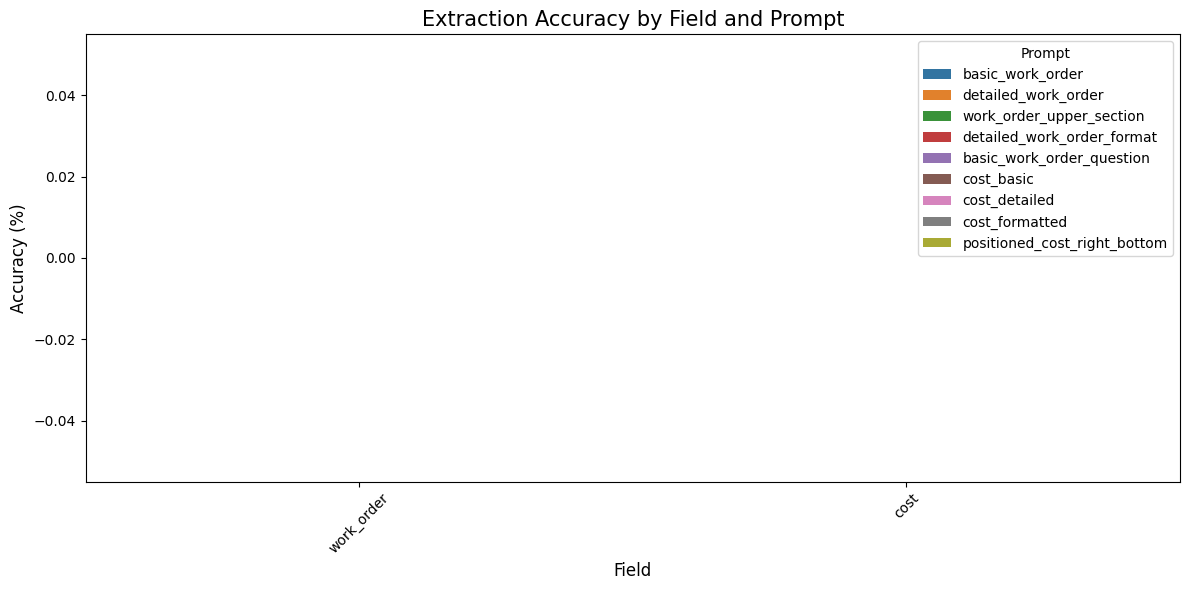

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from src.results.schema import (
    ExperimentResult, 
    PromptPerformance, 
    IndividualExtractionResult, 
    ExtractionStatus
)
from scipy import stats

# 1. Load experiment results
# First, try to load using the new schema method
try:
    experiment_result = ExperimentResult.load_from_file(analysis_params['results_path'])
    experiment_results = json.load(open(analysis_params['results_path'], 'r'))
    print("✅ Loaded experiment results using schema method")
except Exception as e:
    print(f"⚠️ Falling back to traditional loading: {e}")
    with open(analysis_params['results_path'], 'r') as f:
        experiment_results = json.load(f)

# 2. Prepare cross-field performance DataFrame
performance_data = []

for field, field_results in experiment_results['results'].items():
    if 'prompt_results' in field_results:
        for prompt_result in field_results['prompt_results']:
            prompt_name = prompt_result['prompt_name']
            
            # Aggregate metrics for this prompt
            exact_matches = sum(1 for r in prompt_result['results'] if r.get('exact_match', False))
            total_items = len(prompt_result['results'])
            accuracy = exact_matches / total_items if total_items > 0 else 0
            
            avg_cer = sum(r.get('character_error_rate', 1.0) for r in prompt_result['results']) / total_items
            avg_processing_time = sum(r.get('processing_time', 0) for r in prompt_result['results']) / total_items
            
            performance_data.append({
                'Field': field,
                'Prompt': prompt_name,
                'Accuracy': accuracy * 100,
                'Avg Character Error Rate': avg_cer,
                'Avg Processing Time': avg_processing_time
            })

performance_df = pd.DataFrame(performance_data)

# 3. Visualization: Multi-field Accuracy Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Field', y='Accuracy', hue='Prompt', data=performance_df)
plt.title('Extraction Accuracy by Field and Prompt', fontsize=15)
plt.xlabel('Field', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(experiment_paths['results_dir'] / 'multi_field_accuracy.png')
plt.close()

# 4. Visualization: Character Error Rate Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Field', y='Avg Character Error Rate', hue='Prompt', data=performance_df)
plt.title('Character Error Rate by Field and Prompt', fontsize=15)
plt.xlabel('Field', fontsize=12)
plt.ylabel('Average Character Error Rate', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(experiment_paths['results_dir'] / 'multi_field_cer.png')
plt.close()

# 5. Detailed Performance Summary
print("🔍 Multi-Field Extraction Performance Summary:")
for index, row in performance_df.iterrows():
    print(f"\n{row['Field'].upper()} - {row['Prompt']}:")
    print(f"  Accuracy:             {row['Accuracy']:.2f}%")
    print(f"  Avg CER:              {row['Avg Character Error Rate']:.4f}")
    print(f"  Avg Processing Time:  {row['Avg Processing Time']:.2f}s")

# 6. Identify Best Performing Prompts
best_prompts = performance_df.loc[performance_df.groupby('Field')['Accuracy'].idxmax()]
print("\n🏆 Best Performing Prompts:")
print(best_prompts[['Field', 'Prompt', 'Accuracy']])

# 7. Statistical Significance (Basic t-test between prompts)
print("\n📊 Statistical Significance Analysis:")
for field in experiment_results['results'].keys():
    field_prompts = performance_df[performance_df['Field'] == field]
    
    if len(field_prompts) > 1:
        print(f"\n{field.upper()} Prompt Comparison:")
        prompt_accuracies = [group['Accuracy'].values for name, group in field_prompts.groupby('Prompt')]
        
        # Pairwise t-tests
        for i in range(len(prompt_accuracies)):
            for j in range(i+1, len(prompt_accuracies)):
                t_stat, p_value = stats.ttest_ind(prompt_accuracies[i], prompt_accuracies[j])
                print(f"  {field_prompts['Prompt'].iloc[i]} vs {field_prompts['Prompt'].iloc[j]}:")
                print(f"    p-value: {p_value:.4f}")
                print(f"    Statistically significant: {p_value < 0.05}")

# 8. Save comprehensive analysis
analysis_summary = {
    'performance_data': performance_data,
    'best_prompts': best_prompts.to_dict('records')
}

# Save analysis summary
with open(experiment_paths['results_dir'] / 'analysis_summary.json', 'w') as f:
    json.dump(analysis_summary, f, indent=2)

# If ExperimentResult is available, save using schema method
if 'experiment_result' in locals():
    schema_results_path = experiment_paths['results_dir'] / f"schema_analysis_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    experiment_result.save_to_file(schema_results_path)
    print(f"\n💾 Schema-based results saved to: {schema_results_path}")

print("\n✅ Results analysis complete. Visualizations and summary saved.")